In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from textblob import TextBlob
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GRU,LSTM
from tensorflow.keras.models import Model
import keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def preparing_data(file_name):
    files=open(file_name,'r')
    sentences=files.readlines()
    files.close()
    # print(lines)
    sms_text=[]
    english_text=[]

    for index,sentence in enumerate(sentences):
        if index%3==0:
           sms_text.append(sentence.strip())
        elif index%3==1:
            english_text.append(sentence.strip())
        else:
            pass
    return sms_text,english_text             



In [ ]:
# file_name='/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/en2cn-2k.en2nen2cn'
# sms_text,english_text=preparing_data(file_name)
# print(len(sms_text), len(english_text))


In [ ]:
# data={'SMS_TEXT':sms_text,'ENGLISH_TEXT': english_text}
# data=pd.DataFrame(data)
# print(data.head(10))


In [ ]:
# data.head()

In [ ]:
# data.to_csv('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/rawdata.csv', index = False)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/rawdata.csv')


In [ ]:
print("Data Shape",data.shape)

Data Shape (2000, 2)


In [ ]:
data.head()

,SMS_TEXT,ENGLISH_TEXT
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [ ]:
def preprocessing_steps(data):
    """Applying the length on both sms_text and english_text and filtering the sentences based on length 
    adding start token and end token for inputs and output dataframe
    \t-> start token which represents start of the sentence
    \n-> end token which represents end of the sentence.
    Removing the sms_length, english_length, and ENGLISH_TEXT and appending ENGLISH_INPUT,ENGLISH_OUTPUT for the decoder."""
    data['sms_length']=data['SMS_TEXT'].apply(len)
    data['eng_length']=data['ENGLISH_TEXT'].apply(len)
    data=data[data['sms_length']<=170]
    data=data[data['eng_length']<=202]
    data['ENGLISH_INPUT']='\t '+data['ENGLISH_TEXT'].astype(str)
    data['ENGLISH_OUTPUT']=data['ENGLISH_TEXT'].astype(str)+' \n'
    data=data.drop(['sms_length','eng_length','ENGLISH_TEXT'],axis=1)
    return data

In [ ]:
preprocessed_data=preprocessing_steps(data)
print(preprocessed_data.shape)
preprocessed_data.iloc[0]['ENGLISH_INPUT']=str(preprocessed_data.iloc[0]['ENGLISH_INPUT'])+' \n'
preprocessed_data.iloc[0]['ENGLISH_OUTPUT']=str(preprocessed_data.iloc[0]['ENGLISH_OUTPUT'])+' \n'

(1993, 3)


In [ ]:
preprocessed_data.iloc[0][1]

'\t Do you want me to reserve seat for you or not? \n'

In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data= train_test_split(preprocessed_data,test_size=0.01, random_state=11)
print(train_data.shape)
print(test_data.shape)


(1973, 3)
(20, 3)


In [ ]:
def preparing_data_for_model(preprocessed_data):
    """1. Creating input and output characters list.
       2. Creating input and output vocabluary list
       3. Initialising np.array with zeros for encoder_input_data,decoder_input_data and decoder_output_data.
       4. One hot encoding of encoder_input_data,decoder_input_data and decoder_output_data.
       5. Decoder_output_data would be one time step ahead of decoder_input_data which is known as teacher enforcing.
       6. Return input_token_index,output_token_index,encoder_input_data,decoder_output_data,decoder_input_data.
    """
    #creating vocabluary.
    input_charcters_list=sorted(list(set(preprocessed_data['SMS_TEXT'].apply(list).sum())))
    output_charcters_list=sorted(list(set(preprocessed_data['ENGLISH_INPUT'].apply(list).sum())))
    input_token_index = dict((c, i) for i, c in enumerate(input_charcters_list))   
    output_token_index=dict((c, i) for i, c in enumerate(output_charcters_list))
    print(len(input_token_index))
    print(len(output_token_index))
    #intialising np.array with zeros for one hot encoding.
    encoder_input_data = np.zeros((len(preprocessed_data),170,len(input_token_index)), dtype="int32")
    decoder_input_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    decoder_output_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    #one hot encoding of encoder input data
    for i,input_text in enumerate(list(preprocessed_data['SMS_TEXT'].values)):
        for t,char in enumerate(input_text):
            encoder_input_data[i,t,input_token_index[char]]=1
        encoder_input_data[i,t+1,input_token_index[" "]]=1   
    #one hot encoding of decoder input data and decoder output data   
    for i,output_text in enumerate(list(preprocessed_data['ENGLISH_INPUT'].values)):
        for t,char in enumerate(output_text):
            decoder_input_data[i,t,output_token_index[char]]=1
            if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
               decoder_output_data[i, t - 1, output_token_index[char]] = 1
        decoder_input_data[i, t + 1 :, output_token_index[" "]] = 1
        decoder_output_data[i, t:, output_token_index[" "]] = 1   
    return input_token_index,output_token_index,encoder_input_data,decoder_input_data,decoder_output_data

In [ ]:
# not changed
def preparing_val_data_for_model(preprocessed_data,input_token_index,output_token_index):
    """1. Getting the arguments as data,input token vocabulary and output token vocabulary.
       2. Initialising np.array with zeros for encoder_input_data,decoder_input_data and decoder_output_data.
       3. One hot encoding of encoder_input_data,decoder_input_data and decoder_output_data.
       4. Decoder_output_data would be one time step ahead of decoder_input_data which is known as teacher enforcing.
       5. Return encoder_input_data,decoder_output_data,decoder_input_data.
    """
    
   
    #intialising np.array with zeros for one hot encoding.
    encoder_input_data = np.zeros((len(preprocessed_data),170,len(input_token_index)), dtype="int32")
    decoder_input_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    decoder_output_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    #one hot encoding of encoder input data
    for i,input_text in enumerate(list(preprocessed_data['SMS_TEXT'].values)):
        for t,char in enumerate(input_text):
            encoder_input_data[i,t,input_token_index[char]]=1
        encoder_input_data[i,t+1,input_token_index[" "]]=1   
    #one hot encoding of decoder input data and decoder output data   
    for i,output_text in enumerate(list(preprocessed_data['ENGLISH_INPUT'].values)):
        for t,char in enumerate(output_text):
            decoder_input_data[i,t,output_token_index[char]]=1
            if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
               decoder_output_data[i, t - 1, output_token_index[char]] = 1
        decoder_input_data[i, t + 1 :, output_token_index[" "]] = 1
        decoder_output_data[i, t:, output_token_index[" "]] = 1   
    return encoder_input_data,decoder_input_data,decoder_output_data

In [ ]:

#for trained data
input_token_ind,output_token_ind,enc_input_data,dec_input_data,dec_output_data=preparing_data_for_model(train_data)
#for validation data
cv_enc_input_data,cv_dec_input_data,cv_dec_output_data=preparing_val_data_for_model(test_data,input_token_ind,output_token_ind)

103
92


In [ ]:
# decoder_output_data.shape

# GRU

In [ ]:

tf.keras.backend.clear_session()
enc_inputs = tf.keras.Input(shape=(None,len(input_token_ind)))
enc = tf.keras.layers.GRU(100, return_state=True)
enc_outputs,state_h= enc(enc_inputs)
#storing encoder states
enc_states = state_h
 
# Set up the decoder, using encoder_states as initial state.
dec_inputs = tf.keras.Input(shape=(None, len(output_token_ind)))
 
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
dec_gru = tf.keras.layers.GRU(100, return_sequences=True, return_state=True)
dec_outputs, _ = dec_gru(dec_inputs, initial_state=enc_states)
dec_dense = tf.keras.layers.Dense(len(output_token_ind), activation="softmax")
dec_outputs = dec_dense(dec_outputs)
 
# Define the model
model = tf.keras.Model([enc_inputs, dec_inputs], dec_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 103)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 100), (None, 61500       input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, None, 100),  58200       input_2[0][0]                    
                                                                 gru[0][1]                    

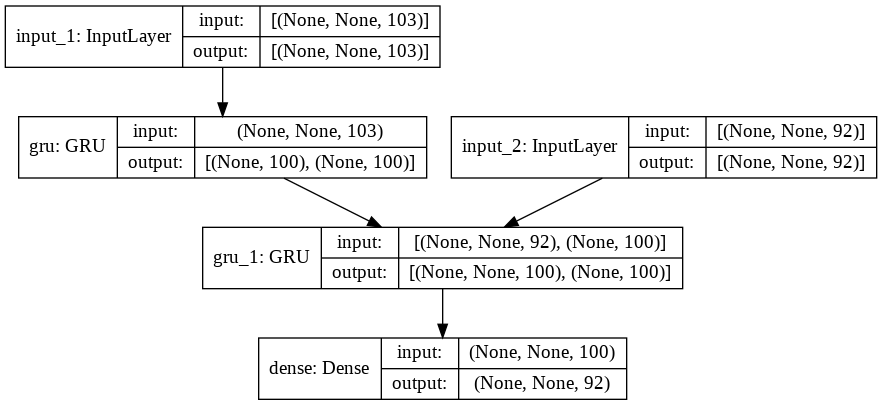

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, verbose=0,
    mode='auto', min_delta=0.00001, cooldown=0, min_lr=0,
)

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.fit([enc_input_data, dec_input_data],dec_output_data,validation_data=([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data),batch_size=64,epochs=100,callbacks=[rlp])

Epoch 1/100
31/31 [==============================] - 6s 58ms/step - loss: 1.7960 - val_loss: 1.1431
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 1.0691 - val_loss: 0.9142
Epoch 3/100
31/31 [==============================] - 1s 28ms/step - loss: 0.9199 - val_loss: 0.8253
Epoch 4/100
31/31 [==============================] - 1s 28ms/step - loss: 0.8404 - val_loss: 0.7699
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 0.7855 - val_loss: 0.7243
Epoch 6/100
31/31 [==============================] - 1s 27ms/step - loss: 0.7428 - val_loss: 0.6903
Epoch 7/100
31/31 [==============================] - 1s 28ms/step - loss: 0.7103 - val_loss: 0.6630
Epoch 8/100
31/31 [==============================] - 1s 27ms/step - loss: 0.6832 - val_loss: 0.6369
Epoch 9/100
31/31 [==============================] - 1s 27ms/step - loss: 0.6596 - val_loss: 0.6175
Epoch 10/100
31/31 [==============================] - 1s 27ms/step - loss: 0.6397 - val_loss: 0.6030

In [ ]:
# optimizer = tf.keras.optimizers.Adam(0.0001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy')
# model.fit([enc_input_data, dec_input_data],dec_output_data,validation_data=([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data),batch_size=64,epochs=1000,callbacks=[rlp])

In [ ]:
# optimizer = tf.keras.optimizers.Adam(0.0001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy')
# model.fit([enc_input_data, dec_input_data],dec_output_data,validation_data=([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data),batch_size=64,epochs=1000,callbacks=[rlp])

In [ ]:

model.save('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/GRU_model_v2.h5')

In [ ]:

model = tf.keras.models.load_model('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/GRU_model_v2.h5')

Prediction

In [ ]:
int_2_char_input=dict((i, char) for char, i in input_token_ind.items())
int_2_char_output=dict((i,char) for char, i in output_token_ind.items())
print(int_2_char_input)
print(int_2_char_output)

{0: ' ', 1: '!', 2: '"', 3: '#', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '<', 29: '=', 30: '>', 31: '?', 32: '@', 33: 'A', 34: 'B', 35: 'C', 36: 'D', 37: 'E', 38: 'F', 39: 'G', 40: 'H', 41: 'I', 42: 'J', 43: 'K', 44: 'L', 45: 'M', 46: 'N', 47: 'O', 48: 'P', 49: 'Q', 50: 'R', 51: 'S', 52: 'T', 53: 'U', 54: 'V', 55: 'W', 56: 'X', 57: 'Y', 58: 'Z', 59: '^', 60: '_', 61: 'a', 62: 'b', 63: 'c', 64: 'd', 65: 'e', 66: 'f', 67: 'g', 68: 'h', 69: 'i', 70: 'j', 71: 'k', 72: 'l', 73: 'm', 74: 'n', 75: 'o', 76: 'p', 77: 'q', 78: 'r', 79: 's', 80: 't', 81: 'u', 82: 'v', 83: 'w', 84: 'x', 85: 'y', 86: 'z', 87: '£', 88: 'É', 89: 'Ñ', 90: 'Ü', 91: 'à', 92: 'ä', 93: 'å', 94: 'è', 95: 'é', 96: 'ì', 97: 'ñ', 98: 'ò', 99: 'ö', 100: 'ø', 101: 'ù', 102: 'ü'}
{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '"', 5: '#', 6: '$', 7: '%', 8: '&', 9: "

In [ ]:

enc_inputs = model.input[0]  # input_1
enc_outputs, state_h_enc = model.layers[2].output  # gru
enc_states = state_h_enc
enc_model = tf.keras.Model(enc_inputs, enc_states)

enc_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 103)]       0         
_________________________________________________________________
gru (GRU)                    [(None, 100), (None, 100) 61500     
Total params: 61,500
Trainable params: 61,500
Non-trainable params: 0
_________________________________________________________________


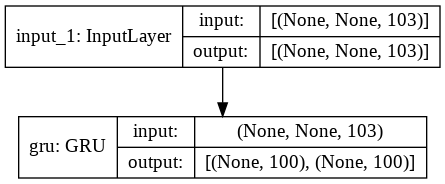

In [ ]:
tf.keras.utils.plot_model(enc_model, show_shapes=True)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, None, 100),  58200       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 92)     9292        gru_1[1][0]                

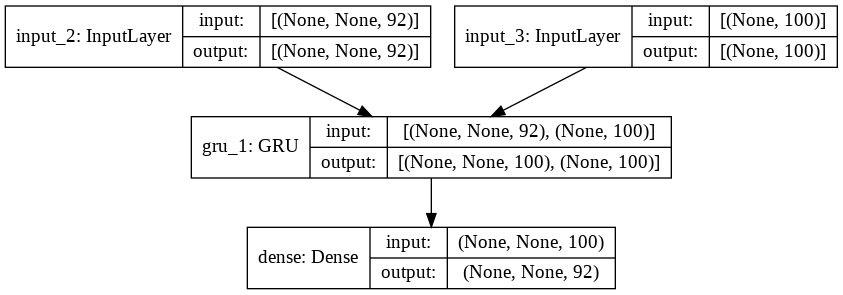

In [ ]:

dec_inputs=model.inputs[1]
dec_state_input_h = tf.keras.Input(shape=(100,))
dec_outputs, state_h_dec= model.layers[3](dec_inputs, initial_state=dec_state_input_h)
# decoder_model = tf.keras.Model([decoder_inputs,decoder_state_input_h],decoder_outputs)
dec_states =state_h_dec
dec_dense = model.layers[4]
dec_outputs = dec_dense(dec_outputs)
dec_model = tf.keras.Model((dec_inputs,dec_state_input_h),(dec_outputs,dec_states))

dec_model.summary()
tf.keras.utils.plot_model(dec_model, show_shapes=True)

In [ ]:

# dec_inputs=model.inputs[1]
# dec_state_input_h = tf.keras.Input(shape=(100,))
# dec_outputs, state_h_dec= model.layers[3](dec_inputs, initial_state=dec_state_input_h)
# dec_model = tf.keras.Model([dec_inputs,dec_state_input_h],dec_outputs)
# dec_states =state_h_dec
# dec_dense = model.layers[4]
# dec_outputs = dec_dense(dec_outputs)
# dec_model = tf.keras.Model((dec_inputs,dec_state_input_h),(dec_outputs,dec_states))

# dec_model.summary()
# tf.keras.utils.plot_model(dec_model, show_shapes=True)

In [ ]:

def predictions(input_seq):
    # print(np.argmax(input_seq))
    states=enc_model(input_seq)
    target_seq = np.zeros((1, 1, 92))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, output_token_ind["\t"]] = 1
    stop_condition = False
    dec_sentence = ""
    
    while not stop_condition:
        
        output_tokens,states= dec_model((target_seq,states))
        sampled_token_ind = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        sampled_char = int_2_char_output[sampled_token_ind]
        if (sampled_char == '\n' or len(dec_sentence) > 202):
            stop_condition = True
            return dec_sentence
        
        dec_sentence += sampled_char
        target_seq = np.zeros((1, 1, 92))
        target_seq[0, 0, sampled_token_ind] = 1
    
    return dec_sentence

In [ ]:
for seq in range(len(test_data)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    print("English_TEXT")
    print(test_data['ENGLISH_OUTPUT'].iloc[seq])
    input_seq = cv_enc_input_data[seq:seq+1]
    print("Pred_Sentence")
    print(predictions(input_seq))
    print()

English_TEXT
Look at that then no need to go already. So pissed. Don't know what's wrong with it. 

Pred_Sentence
 OK. I am still the more the book to see you the meeting and so meet you all can come.                                                                                                                     

English_TEXT
Yup. Taken already. Thanks. 

Pred_Sentence
 Yes. I want to go to see.                                                                                                                                                                                 

English_TEXT
Haha, okay, hope you can remember to help me to ask. Hehe. 

Pred_Sentence
 Haha. Okay. I am still then see you the meet at 12 to me.                                                                                                                                                 

English_TEXT
I'm still at Computer Centre. There's still a long queue. Sigh. I might not be able to meet you. 

Pred_Sentence


In [ ]:
model.evaluate([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data)


1/1 [==============================] - 1s 712ms/step - loss: 0.5313


0.531344473361969

# LSTM

In [ ]:

tf.keras.backend.clear_session()
enc_inputs = tf.keras.Input(shape=(None,len(input_token_ind)))
enc = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs,state_h,state_c= enc(enc_inputs)
#storing encoder states
enc_states = [state_h,state_c]
 
# Set up the decoder, using encoder_states as initial state.
dec_inputs = tf.keras.Input(shape=(None, len(output_token_ind)))
 
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
dec_lstm = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)
dec_outputs, _,_ = dec_lstm(dec_inputs, initial_state=enc_states)
dec_dense = tf.keras.layers.Dense(len(output_token_ind), activation="softmax")
dec_outputs = dec_dense(dec_outputs)
 
# Define the model
model_lstm = tf.keras.Model([enc_inputs, dec_inputs], dec_outputs)
model_lstm.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 103)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 81600       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 100),  77200       input_2[0][0]                    
                                                                 lstm[0][1]                   

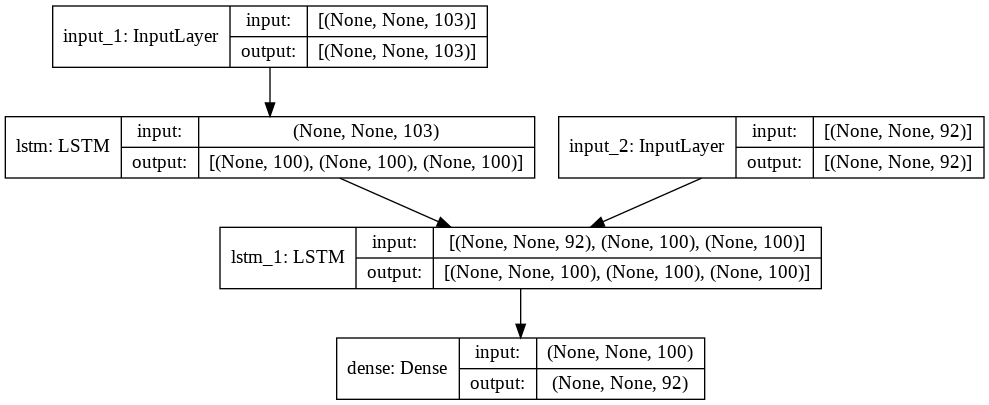

In [ ]:
tf.keras.utils.plot_model(model_lstm, show_shapes=True)


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy')
model_lstm.fit([enc_input_data, dec_input_data],dec_output_data,validation_data=([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data),batch_size=64,epochs=100,callbacks=[rlp])


Epoch 1/100
31/31 [==============================] - 5s 58ms/step - loss: 1.6620 - val_loss: 1.2018
Epoch 2/100
31/31 [==============================] - 1s 31ms/step - loss: 1.1802 - val_loss: 1.0598
Epoch 3/100
31/31 [==============================] - 1s 31ms/step - loss: 1.0326 - val_loss: 0.8752
Epoch 4/100
31/31 [==============================] - 1s 31ms/step - loss: 0.8803 - val_loss: 0.8024
Epoch 5/100
31/31 [==============================] - 1s 31ms/step - loss: 0.8217 - val_loss: 0.7615
Epoch 6/100
31/31 [==============================] - 1s 31ms/step - loss: 0.7882 - val_loss: 0.7365
Epoch 7/100
31/31 [==============================] - 1s 31ms/step - loss: 0.7613 - val_loss: 0.7176
Epoch 8/100
31/31 [==============================] - 1s 30ms/step - loss: 0.7410 - val_loss: 0.6997
Epoch 9/100
31/31 [==============================] - 1s 31ms/step - loss: 0.7231 - val_loss: 0.6821
Epoch 10/100
31/31 [==============================] - 1s 31ms/step - loss: 0.7074 - val_loss: 0.6772

In [ ]:

model_lstm.save('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/LSTM_model_v2.h5')

In [ ]:

model = tf.keras.models.load_model('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/LSTM_model_v2.h5')

Prediction

In [ ]:
# int_2_char_input=dict((i, char) for char, i in input_token_index.items())
# int_2_char_output=dict((i,char) for char, i in output_token_index.items())
# print(int_2_char_input)
# print(int_2_char_output)

In [ ]:

enc_inputs = model.input[0]  
enc_outputs, state_h_enc, state_c_enc= model.layers[2].output 
enc_states = [state_h_enc,state_c_enc]
enc_model = tf.keras.Model(enc_inputs, enc_states)

enc_model.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 103)]       0         
_________________________________________________________________
lstm (LSTM)                  [(None, 100), (None, 100) 81600     
Total params: 81,600
Trainable params: 81,600
Non-trainable params: 0
_________________________________________________________________


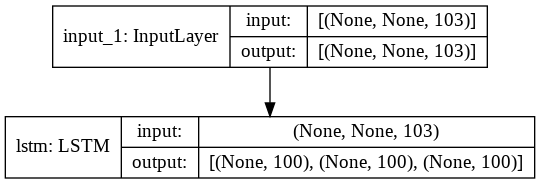

In [ ]:
tf.keras.utils.plot_model(enc_model, show_shapes=True)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 100),  77200       input_2[0][0]                    
                                                                 input_3[0][0]              

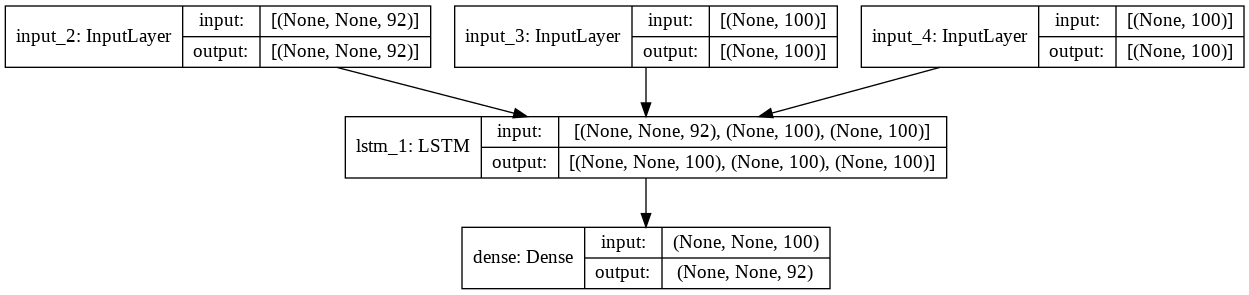

In [ ]:

dec_inputs=model.inputs[1]
dec_state_input_h = tf.keras.Input(shape=(100,))
dec_state_input_c= tf.keras.Input(shape=(100,))
dec_states_inputs = [dec_state_input_h, dec_state_input_c]

dec_outputs, state_h_dec,state_c_dec= model.layers[3](dec_inputs, initial_state=dec_states_inputs)

dec_states =[state_h_dec, state_c_dec]
dec_dense = model.layers[4]
dec_outputs = dec_dense(dec_outputs)
dec_model = tf.keras.Model((dec_inputs,dec_states_inputs),(dec_outputs,dec_states))

dec_model.summary()
tf.keras.utils.plot_model(dec_model, show_shapes=True)

In [ ]:

def predictions(input_seq):
    # print(np.argmax(input_seq))
    states=enc_model(input_seq)
    target_seq = np.zeros((1, 1, 92))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, output_token_ind["\t"]] = 1
    stop_condition = False
    dec_sentence = ""
    
    while not stop_condition:
        
        output_tokens,states= dec_model((target_seq,states))
        sampled_token_ind = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        sampled_char = int_2_char_output[sampled_token_ind]
        if (sampled_char == '\n' or len(dec_sentence) > 202):
            stop_condition = True
            return dec_sentence
        
        dec_sentence += sampled_char
        target_seq = np.zeros((1, 1, 92))
        target_seq[0, 0, sampled_token_ind] = 1
    
    return dec_sentence

In [ ]:
for seq in range(len(test_data)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    print("English_TEXT")
    print(test_data['ENGLISH_OUTPUT'].iloc[seq])
    input_seq = cv_enc_input_data[seq:seq+1]
    print("Pred_Sentence")
    print(predictions(input_seq))
    print()

English_TEXT
Look at that then no need to go already. So pissed. Don't know what's wrong with it. 

Pred_Sentence
 Anything the back to see you all to be at the bus the says and the way, I don't know where are you all the way, I want to go to see you already.                                                          

English_TEXT
Yup. Taken already. Thanks. 

Pred_Sentence
 Yes. I am not studying to see you already.                                                                                                                                                                

English_TEXT
Haha, okay, hope you can remember to help me to ask. Hehe. 

Pred_Sentence
 Haha. I am not studying to see you already.                                                                                                                                                               

English_TEXT
I'm still at Computer Centre. There's still a long queue. Sigh. I might not be able to meet you. 

Pred_Sentence


In [ ]:
model.evaluate([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data)


1/1 [==============================] - 1s 793ms/step - loss: 0.5076


0.5075626373291016

# Words

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/rawdata.csv')


In [ ]:
print("Data Shape",data.shape)

Data Shape (2000, 2)


In [ ]:
data.head()

,SMS_TEXT,ENGLISH_TEXT
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [ ]:
def preprocessing_steps(data):
    """Applying the length on both sms_text and english_text and filtering the sentences based on length 
    adding start token and end token for inputs and output dataframe
    \t-> start token which represents start of the sentence
    \n-> end token which represents end of the sentence.
    Removing the sms_length, english_length, and ENGLISH_TEXT and appending ENGLISH_INPUT,ENGLISH_OUTPUT for the decoder."""
    data['sms_length']=data['SMS_TEXT'].str.split().apply(len)
    data['eng_length']=data['ENGLISH_TEXT'].str.split().apply(len)
    data=data[data['sms_length']<=39]
    data=data[data['eng_length']<=40]
    data['ENGLISH_INPUT']=data['ENGLISH_TEXT'].astype(str)
    data['ENGLISH_OUTPUT']=data['ENGLISH_TEXT'].astype(str)+' \n'
    # data['ENGLISH_OUTPUT']=data['ENGLISH_TEXT'].astype(str)+' \n'

    data=data.drop(['sms_length','eng_length','ENGLISH_TEXT'],axis=1)
    return data

In [ ]:
data.head()

,SMS_TEXT,ENGLISH_TEXT
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [ ]:
preprocessed_data=preprocessing_steps(data)
print(preprocessed_data.shape)
preprocessed_data.iloc[0]['ENGLISH_INPUT']="\t " + str(preprocessed_data.iloc[0]['ENGLISH_INPUT'])+' \n'
preprocessed_data.iloc[0]['ENGLISH_OUTPUT']="\t " + str(preprocessed_data.iloc[0]['ENGLISH_OUTPUT'])+' \n'

(1991, 3)


In [ ]:
preprocessed_data.iloc[0][1] = "\t " + preprocessed_data.iloc[0][2]

In [ ]:
preprocessed_data

,SMS_TEXT,ENGLISH_INPUT,ENGLISH_OUTPUT
0,"U wan me to ""chop"" seat 4 u nt?",\t Do you want me to reserve seat for you or n...,\t Do you want me to reserve seat for you or n...
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?,I'm Thai. What do you do? \n
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...,Hi! How did your week go? Haven't heard from y...
...,...,...,...
1994,Hi tina ...,Hi tina.,Hi tina. \n
1995,Hmmm... Thk i usually book on wkends... Depend...,Hmm. I think I usually book on weekends. It de...,Hmm. I think I usually book on weekends. It de...
1997,We r near coca oredi...,We are near Coca already.,We are near Coca already. \n
1998,hall Eleven. Got lectures le mah.èn forget abt...,Hall eleven. Got lectures. And forget about co...,Hall eleven. Got lectures. And forget about co...


In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data= train_test_split(preprocessed_data,test_size=0.01, random_state=11)
print(train_data.shape)
print(test_data.shape)


(1971, 3)
(20, 3)


In [ ]:
def preparing_data_for_model(preprocessed_data):
    """1. Creating input and output characters list.
       2. Creating input and output vocabluary list
       3. Initialising np.array with zeros for encoder_input_data,decoder_input_data and decoder_output_data.
       4. One hot encoding of encoder_input_data,decoder_input_data and decoder_output_data.
       5. Decoder_output_data would be one time step ahead of decoder_input_data which is known as teacher enforcing.
       6. Return input_token_index,output_token_index,encoder_input_data,decoder_output_data,decoder_input_data.
    """
    #creating vocabluary.
    input_charcters_list=sorted(list(set(preprocessed_data['SMS_TEXT'].str.split().apply(list).sum())))
    output_charcters_list=sorted(list(set(preprocessed_data['ENGLISH_INPUT'].str.split().apply(list).sum())))
    output_charcters_list.append("\t")

    input_token_index = dict((c, i) for i, c in enumerate(input_charcters_list))   
    output_token_index=dict((c, i) for i, c in enumerate(output_charcters_list))
    print(len(input_token_index))
    print(len(output_token_index))
    #intialising np.array with zeros for one hot encoding.
    encoder_input_data = np.zeros((len(preprocessed_data),39,len(input_token_index)), dtype="int32")
    decoder_input_data = np.zeros((len(preprocessed_data),40,len(output_token_index)), dtype="int32")
    decoder_output_data = np.zeros((len(preprocessed_data),40,len(output_token_index)), dtype="int32")
    #one hot encoding of encoder input data
    for i,input_text in enumerate(list(preprocessed_data['SMS_TEXT'].str.split().values)):
        for t,char in enumerate(input_text):
            # print(len())
            if char in input_token_index:
              # print(t)
              encoder_input_data[i,t,input_token_index[char]]=1
        # encoder_input_data[i,t+1,input_token_index[" "]]=1   
    #one hot encoding of decoder input data and decoder output data   
    for i,output_text in enumerate(list(preprocessed_data['ENGLISH_INPUT'].str.split().values)):
        for t,char in enumerate(output_text):
            if char in output_token_index:
              decoder_input_data[i,t,output_token_index[char]]=1
              if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
                decoder_output_data[i, t - 1, output_token_index[char]] = 1
        # decoder_input_data[i, t + 1 :, output_token_index[" "]] = 1
        # decoder_output_data[i, t:, output_token_index[" "]] = 1   
    return input_token_index,output_token_index,encoder_input_data,decoder_input_data,decoder_output_data

In [ ]:
# not changed
def preparing_val_data_for_model(preprocessed_data,input_token_index,output_token_index):
    """1. Getting the arguments as data,input token vocabulary and output token vocabulary.
       2. Initialising np.array with zeros for encoder_input_data,decoder_input_data and decoder_output_data.
       3. One hot encoding of encoder_input_data,decoder_input_data and decoder_output_data.
       4. Decoder_output_data would be one time step ahead of decoder_input_data which is known as teacher enforcing.
       5. Return encoder_input_data,decoder_output_data,decoder_input_data.
    """
    
   
    #intialising np.array with zeros for one hot encoding.
    encoder_input_data = np.zeros((len(preprocessed_data),170,len(input_token_index)), dtype="int32")
    decoder_input_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    decoder_output_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    #one hot encoding of encoder input data
    for i,input_text in enumerate(list(preprocessed_data['SMS_TEXT'].str.split().values)):
        for t,char in enumerate(input_text):
            if char in input_token_index:

             encoder_input_data[i,t,input_token_index[char]]=1
        # encoder_input_data[i,t+1,input_token_index[" "]]=1   
    #one hot encoding of decoder input data and decoder output data   
    for i,output_text in enumerate(list(preprocessed_data['ENGLISH_INPUT'].str.split().values)):
        for t,char in enumerate(output_text):
            if char in output_token_index:
               decoder_input_data[i,t,output_token_index[char]]=1
               if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
                decoder_output_data[i, t - 1, output_token_index[char]] = 1
        # decoder_input_data[i, t + 1 :, output_token_index[" "]] = 1
        # decoder_output_data[i, t:, output_token_index[" "]] = 1   
    return encoder_input_data,decoder_input_data,decoder_output_data

In [ ]:

#for trained data
input_token_ind,output_token_ind,enc_input_data,dec_input_data,dec_output_data=preparing_data_for_model(train_data)
#for validation data
cv_enc_input_data,cv_dec_input_data,cv_dec_output_data=preparing_val_data_for_model(test_data,input_token_ind,output_token_ind)

6948
5272


In [ ]:
output_token_ind['\t']

5271

# GRU

In [ ]:

tf.keras.backend.clear_session()
enc_inputs = tf.keras.Input(shape=(None,len(input_token_ind)))
enc = tf.keras.layers.GRU(100, return_state=True)
enc_outputs,state_h= enc(enc_inputs)
#storing encoder states
enc_states = state_h
 
# Set up the decoder, using encoder_states as initial state.
dec_inputs = tf.keras.Input(shape=(None, len(output_token_ind)))
 

dec_gru = tf.keras.layers.GRU(100, return_sequences=True, return_state=True)
dec_outputs, _ = dec_gru(dec_inputs, initial_state=enc_states)
dec_dense = tf.keras.layers.Dense(len(output_token_ind), activation="softmax")
dec_outputs = dec_dense(dec_outputs)
 
# Define the model
model = tf.keras.Model([enc_inputs, dec_inputs], dec_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 6948)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 5272)] 0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 100), (None, 2115000     input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, None, 100),  1612200     input_2[0][0]                    
                                                                 gru[0][1]                    

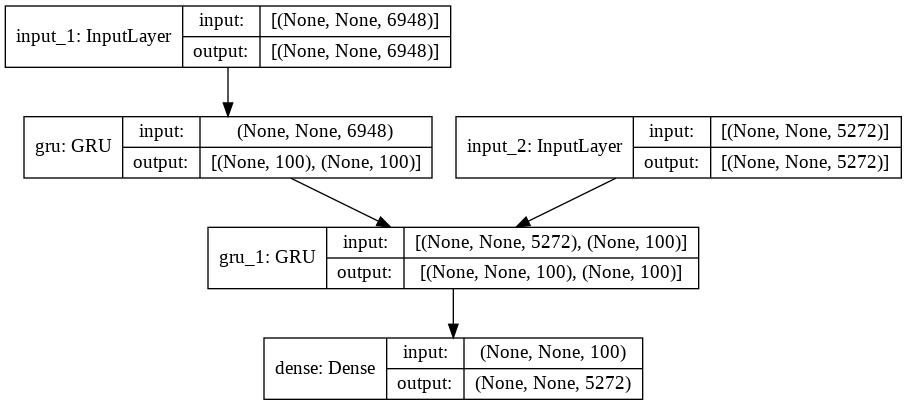

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=10,
    mode='auto', min_delta=0.00001, cooldown=0, min_lr=0.0001,
)

In [ ]:
# optimizer = tf.keras.optimizers.Adam(0.0001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy')
# model.fit([enc_input_data, dec_input_data],dec_output_data,validation_data=([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data),batch_size=64,epochs=500,callbacks=[rlp])

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.fit([enc_input_data, dec_input_data],dec_output_data,validation_data=([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data),batch_size=64,epochs=100,callbacks=[rlp])

Epoch 1/100
31/31 [==============================] - 10s 103ms/step - loss: 2.8277 - val_loss: 0.4297
Epoch 2/100
31/31 [==============================] - 2s 72ms/step - loss: 2.6245 - val_loss: 0.4075
Epoch 3/100
31/31 [==============================] - 2s 73ms/step - loss: 2.5019 - val_loss: 0.3992
Epoch 4/100
31/31 [==============================] - 2s 73ms/step - loss: 2.4755 - val_loss: 0.4149
Epoch 5/100
31/31 [==============================] - 2s 71ms/step - loss: 2.4640 - val_loss: 0.4305
Epoch 6/100
31/31 [==============================] - 2s 73ms/step - loss: 2.4906 - val_loss: 0.4189
Epoch 7/100
31/31 [==============================] - 2s 71ms/step - loss: 2.5389 - val_loss: 0.4347
Epoch 8/100
31/31 [==============================] - 2s 72ms/step - loss: 2.6179 - val_loss: 0.4759

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 9/100
31/31 [==============================] - 2s 72ms/step - loss: 2.3091 - val_loss: 0.3834
Epoch 10/100
31/31

In [ ]:

model.save('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/GRU_word_model_v1.h5')

In [ ]:

model = tf.keras.models.load_model('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/GRU_word_model_v1.h5')

Prediction

In [ ]:
int_2_char_input=dict((i, char) for char, i in input_token_ind.items())
int_2_char_output=dict((i,char) for char, i in output_token_ind.items())
print(int_2_char_input)
print(int_2_char_output)

{0: '!', 1: '!1', 2: '"chop"', 3: '"leafcutter', 4: '"lover"', 5: '#02-34', 6: '#12-517.', 7: '$..', 8: '$15', 9: '$225', 10: '$24', 11: '$30', 12: '$30K', 13: '$375', 14: '$4000', 15: '$45', 16: '$5', 17: '$600', 18: '$600.', 19: '$719...', 20: '$78,', 21: '$800', 22: '&', 23: "'MORROW.", 24: "'bout", 25: "'calrie'", 26: "'okie'", 27: "'rents", 28: "'slim'..", 29: "'ve", 30: "'yo", 31: '(.', 32: '(at', 33: '(sent', 34: '*hugz*hugz*', 35: '+', 36: '+65', 37: '+6590957823', 38: '+6596400001.', 39: ',', 40: ',reached', 41: '-', 42: '-8', 43: '-big', 44: '-book?', 45: '-hugs-', 46: '-if', 47: '-short', 48: '.', 49: '..', 50: '...', 51: '.....', 52: '......', 53: '...But', 54: '...Haha,', 55: '..Hotmail...Hmmm', 56: '016', 57: '016-3785738.', 58: '0164330931', 59: '0165460953', 60: '0165460953.', 61: '0166305681', 62: '0168596707', 63: '019870491', 64: '0845', 65: '1', 66: '1!', 67: '1-15pm', 68: '1-2.', 69: '1.', 70: '1...', 71: '1.30pm', 72: '10', 73: '10%', 74: '10.', 75: '100%', 76: '1

In [ ]:

enc_inputs = model.input[0]  # input_1
enc_outputs, state_h_enc = model.layers[2].output  # gru
enc_states = state_h_enc
enc_model = tf.keras.Model(enc_inputs, enc_states)

enc_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 6948)]      0         
_________________________________________________________________
gru (GRU)                    [(None, 100), (None, 100) 2115000   
Total params: 2,115,000
Trainable params: 2,115,000
Non-trainable params: 0
_________________________________________________________________


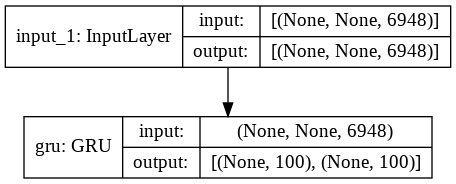

In [ ]:
tf.keras.utils.plot_model(enc_model, show_shapes=True)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 5272)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, None, 100),  1612200     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 5272)   532472      gru_1[1][0]                

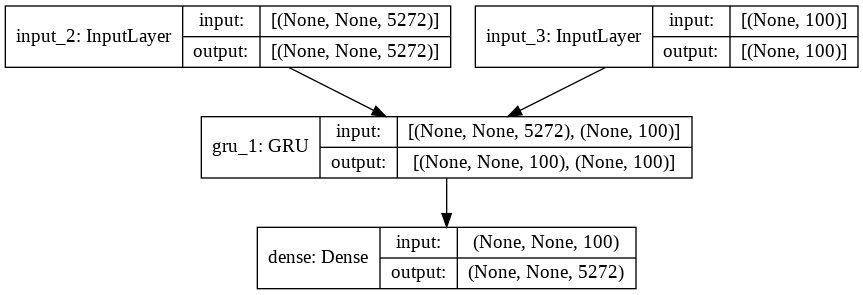

In [ ]:

dec_inputs=model.inputs[1]
dec_state_input_h = tf.keras.Input(shape=(100,))
dec_outputs, state_h_dec= model.layers[3](dec_inputs, initial_state=dec_state_input_h)
# decoder_model = tf.keras.Model([decoder_inputs,decoder_state_input_h],decoder_outputs)
dec_states =state_h_dec
dec_dense = model.layers[4]
dec_outputs = dec_dense(dec_outputs)
dec_model = tf.keras.Model((dec_inputs,dec_state_input_h),(dec_outputs,dec_states))

dec_model.summary()
tf.keras.utils.plot_model(dec_model, show_shapes=True)

In [ ]:
output_token_ind["\t"]

5271

In [ ]:

def predictions(input_seq):
    # print(np.argmax(input_seq))
    states=enc_model(input_seq)
    target_seq = np.zeros((1, 1,5272))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, output_token_ind["\t"]] = 1
    stop_condition = False
    dec_sentence = " "
    
    while not stop_condition:
        
        output_tokens,states= dec_model((target_seq,states))
        sampled_token_ind = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        sampled_char = int_2_char_output[sampled_token_ind]
        if (sampled_char == '\n' or len(dec_sentence) > 40):
            stop_condition = True
            return dec_sentence
        
        dec_sentence += sampled_char + " "
        target_seq = np.zeros((1, 1, 5272))
        target_seq[0, 0, sampled_token_ind] = 1
    
    return dec_sentence

In [ ]:
for seq in range(len(test_data)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    print("English_TEXT")
    print(test_data['ENGLISH_OUTPUT'].iloc[seq])
    input_seq = cv_enc_input_data[seq:seq+1]
    print("Pred_Sentence")
    print(predictions(input_seq))
    print()

English_TEXT
Look at that then no need to go already. So pissed. Don't know what's wrong with it. 

Pred_Sentence
 I don't know you want to go to go to go 

English_TEXT
Yup. Taken already. Thanks. 

Pred_Sentence
 tazz, I don't know you want to go to go 

English_TEXT
Haha, okay, hope you can remember to help me to ask. Hehe. 

Pred_Sentence
 You are you want to go to go to go to go 

English_TEXT
I'm still at Computer Centre. There's still a long queue. Sigh. I might not be able to meet you. 

Pred_Sentence
 I know you want to go to go to go to go 

English_TEXT
Thanks Channel 5 for this great show, you guys rock! 

Pred_Sentence
 can see you want to go to go to go to go 

English_TEXT
It's alright then, thanks! I am just being busy by asking around for a friend. Haha. 

Pred_Sentence
 I don't know you want to go to go to go 

English_TEXT
Hey I have a new number. 91074867. yes, I chose Business Administration. You? 

Pred_Sentence
 know, I don't know you want to go to go 

English_T

In [ ]:
model.evaluate([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data)


1/1 [==============================] - 1s 791ms/step - loss: 0.3631


0.3630616366863251

# LSTM

In [ ]:

tf.keras.backend.clear_session()
enc_inputs = tf.keras.Input(shape=(None,len(input_token_ind)))
enc = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs,state_h,state_c= enc(enc_inputs)
#storing encoder states
enc_states = [state_h,state_c]
 
# Set up the decoder, using encoder_states as initial state.
dec_inputs = tf.keras.Input(shape=(None, len(output_token_ind)))
 
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
dec_lstm = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)
dec_outputs, _,_ = dec_lstm(dec_inputs, initial_state=enc_states)
dec_dense = tf.keras.layers.Dense(len(output_token_ind), activation="softmax")
dec_outputs = dec_dense(dec_outputs)
 
# Define the model
model_lstm = tf.keras.Model([enc_inputs, dec_inputs], dec_outputs)
model_lstm.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 6948)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 5272)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 2819600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 100),  2149200     input_2[0][0]                    
                                                                 lstm[0][1]                   

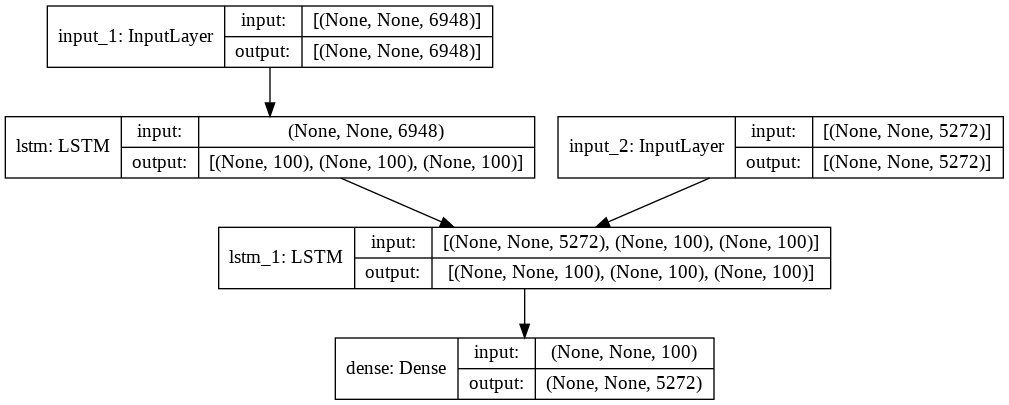

In [ ]:
tf.keras.utils.plot_model(model_lstm, show_shapes=True)


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.1)
model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy')
model_lstm.fit([enc_input_data, dec_input_data],dec_output_data,validation_data=([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data),batch_size=64,epochs=100,callbacks=[rlp])


Epoch 1/100
31/31 [==============================] - 6s 103ms/step - loss: 2.6451 - val_loss: 0.3927
Epoch 2/100
31/31 [==============================] - 2s 76ms/step - loss: 2.4380 - val_loss: 0.3750
Epoch 3/100
31/31 [==============================] - 2s 75ms/step - loss: 2.3630 - val_loss: 0.3778
Epoch 4/100
31/31 [==============================] - 2s 76ms/step - loss: 2.3456 - val_loss: 0.3707
Epoch 5/100
31/31 [==============================] - 2s 75ms/step - loss: 2.3409 - val_loss: 0.3731
Epoch 6/100
31/31 [==============================] - 2s 75ms/step - loss: 2.7169 - val_loss: 0.3874
Epoch 7/100
31/31 [==============================] - 2s 74ms/step - loss: 2.4734 - val_loss: 0.3874
Epoch 8/100
31/31 [==============================] - 2s 74ms/step - loss: 2.3807 - val_loss: 0.3913
Epoch 9/100
31/31 [==============================] - 2s 75ms/step - loss: 2.3782 - val_loss: 0.4010

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 10/100
31/31 

In [ ]:

model_lstm.save('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/LSTM_word_model.h5')

In [ ]:

model = tf.keras.models.load_model('/content/drive/MyDrive/Applied Ai Course assignments/Assiginments/CS2/LSTM_word_model.h5')

Prediction

In [ ]:
# int_2_char_input=dict((i, char) for char, i in input_token_index.items())
# int_2_char_output=dict((i,char) for char, i in output_token_index.items())
# print(int_2_char_input)
# print(int_2_char_output)

In [ ]:

enc_inputs = model.input[0]  # input_1
enc_outputs, state_h_enc, state_c_enc= model.layers[2].output  # gru
enc_states = [state_h_enc,state_c_enc]
enc_model = tf.keras.Model(enc_inputs, enc_states)

enc_model.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 6948)]      0         
_________________________________________________________________
lstm (LSTM)                  [(None, 100), (None, 100) 2819600   
Total params: 2,819,600
Trainable params: 2,819,600
Non-trainable params: 0
_________________________________________________________________


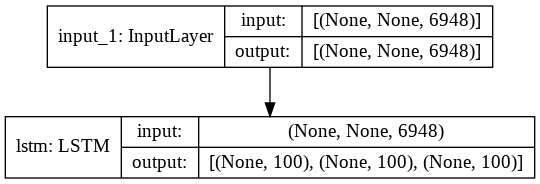

In [ ]:
tf.keras.utils.plot_model(enc_model, show_shapes=True)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 5272)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 100),  2149200     input_2[0][0]                    
                                                                 input_3[0][0]              

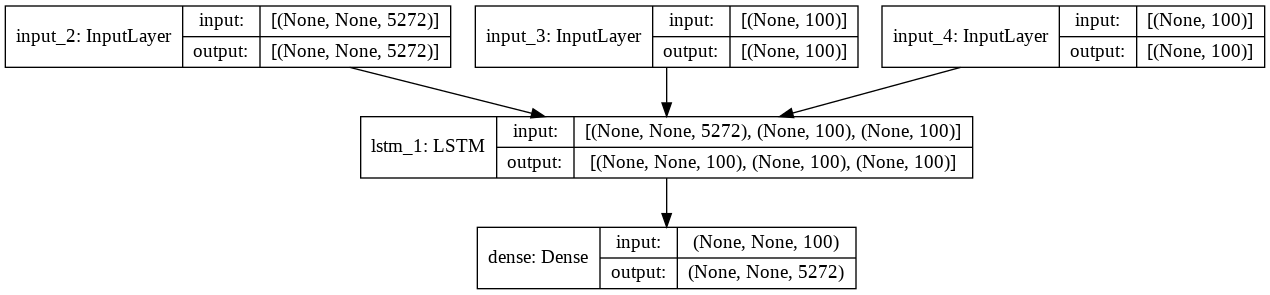

In [ ]:

dec_inputs=model.inputs[1]
dec_state_input_h = tf.keras.Input(shape=(100,))
dec_state_input_c= tf.keras.Input(shape=(100,))
dec_states_inputs = [dec_state_input_h, dec_state_input_c]

dec_outputs, state_h_dec,state_c_dec= model.layers[3](dec_inputs, initial_state=dec_states_inputs)

dec_states =[state_h_dec, state_c_dec]
dec_dense = model.layers[4]
dec_outputs = dec_dense(dec_outputs)
dec_model = tf.keras.Model((dec_inputs,dec_states_inputs),(dec_outputs,dec_states))

dec_model.summary()
tf.keras.utils.plot_model(dec_model, show_shapes=True)

In [ ]:

def predictions(input_seq):
    # print(np.argmax(input_seq))
    states=enc_model(input_seq)
    target_seq = np.zeros((1, 1, 5272))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, output_token_ind["\t"]] = 1
    stop_condition = False
    dec_sentence = ""
    
    while not stop_condition:
        
        output_tokens,states= dec_model((target_seq,states))
        sampled_token_ind = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        sampled_char = int_2_char_output[sampled_token_ind]
        if (sampled_char == '\n' or len(dec_sentence) > 40):
            stop_condition = True
            return dec_sentence
        
        dec_sentence += sampled_char+ " "
        target_seq = np.zeros((1, 1, 5272))
        target_seq[0, 0, sampled_token_ind] = 1
    
    return dec_sentence

In [ ]:
for seq in range(len(test_data)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    print("English_TEXT")
    print(test_data['ENGLISH_OUTPUT'].iloc[seq])
    input_seq = cv_enc_input_data[seq:seq+1]
    print("Pred_Sentence")
    print(predictions(input_seq))
    print()

English_TEXT
Look at that then no need to go already. So pissed. Don't know what's wrong with it. 

Pred_Sentence
I to you you to to to to to to to to to to 

English_TEXT
Yup. Taken already. Thanks. 

Pred_Sentence
I you I to to to to to to to to to to to 

English_TEXT
Haha, okay, hope you can remember to help me to ask. Hehe. 

Pred_Sentence
I you I you to to to to to to to to to to 

English_TEXT
I'm still at Computer Centre. There's still a long queue. Sigh. I might not be able to meet you. 

Pred_Sentence
you you you you you to to to to to to to 

English_TEXT
Thanks Channel 5 for this great show, you guys rock! 

Pred_Sentence
I you I you to to to to to to to to to to 

English_TEXT
It's alright then, thanks! I am just being busy by asking around for a friend. Haha. 

Pred_Sentence
I have at I you to to to to to to to to to 

English_TEXT
Hey I have a new number. 91074867. yes, I chose Business Administration. You? 

Pred_Sentence
I see, I believe you to to to to to to to 

Engl

In [ ]:
model.evaluate([cv_enc_input_data,cv_dec_input_data],cv_dec_output_data)


1/1 [==============================] - 1s 890ms/step - loss: 0.3703


0.3703196346759796